### Pearson correlation between weighted AMT rating and 4 treatment effects

#### 1. Aggregate AMT rating by assigning weights to each rating, then get a probability score for p(y=1|x) by subtraction<br>
#### 2. Calculate pearson correlation between weighted AMT score and 4 treatment effects <br>
#### 3. AUC_ROC for 4 methods with truth defined by weighted AMT <br>

In [2]:
import pandas as pd
import numpy as np
import ast
from IPython.display import display
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

In [3]:
AMT_path = '/data/2/zwang/2018_S_WordTreatment/V2_AMT/'
airbnb_path = '/data/2/zwang/2018_S_WordTreatment/V2_airbnb/'
tw_path = '/data/2/zwang/2018_S_WordTreatment/V2_twitter/'
yp_path = '/data/2/zwang/2018_S_WordTreatment/V2_yelp/'

# tw_file = AMT_path+"AMT_WdSents/Effects/tw_AMT_comboEffects.csv"
# yp_file = AMT_path+"6_amt/results/yp_result_summary_nodummy.csv"
# airbnb_file = AMT_path+"6_amt/results/airbnb_result_summary_nodummy.csv"

#### 1. Aggregate AMT by weighting:
> fifth weighting: [(1,0.2),(2,0.4),(3,0.6),(4,0.8),(5,1)]<br>
> quater weighting: [(1,0),(2,0.25),(3,0.5),(4,0.75),(5,1)]<br>
> weight_function: sum(weight_1\*rating_1+......weight_10\*rating_10)/n_rating(10)<br>

In [51]:
def weight_AMT(data_path):
    for data in ['tw','yp','airbnb']:
        data_pd = pd.read_csv(data_path+data+'_result_summary_nodummy.csv',index_col=False)

        # weight by fifth: 0.2*rating
        data_pd['AMT_src_fifth_weight'] = data_pd['src_ratings'].apply(lambda x: np.mean([float(t)*0.2 for t in ast.literal_eval(x)]))
        data_pd['AMT_tar_fifth_weight'] = data_pd['tar_ratings'].apply(lambda x: np.mean([float(t)*0.2 for t in ast.literal_eval(x)]))
        data_pd['AMT_fifth_effect'] = data_pd['AMT_tar_fifth_weight']-data_pd['AMT_src_fifth_weight']

        # weight by quater: 0.25*(rating-1)
        data_pd['AMT_src_quater_weight'] = data_pd['src_ratings'].apply(lambda x: np.mean([(float(t)-1)*0.25 for t in ast.literal_eval(x)]))
        data_pd['AMT_tar_quater_weight'] = data_pd['tar_ratings'].apply(lambda x: np.mean([(float(t)-1)*0.25 for t in ast.literal_eval(x)]))
        data_pd['AMT_quater_effect'] = data_pd['AMT_tar_quater_weight']-data_pd['AMT_src_quater_weight']

        data_pd.to_csv(data_path+data+'_result_weightedAMT_nodummy.csv',columns=['id','true_y','source','target','src_sentence','tar_sentence',
                                            'knn_effect','vt_effect','ctf_effect','csf_effect',
                                            'src_ratings','tar_ratings','amt_effect_mean','amt_effect_median','amt_effect_mostcom',
                                            'AMT_fifth_effect','AMT_quater_effect'],index=False)
    return data_pd

In [52]:
data_pd = weight_AMT(data_path=AMT_path+"6_amt/results/")

In [53]:
data_pd.head()[['src_ratings','tar_ratings','AMT_fifth_effect','AMT_quater_effect']]

,src_ratings,tar_ratings,AMT_fifth_effect,AMT_quater_effect
0,"[3, 4, 4, 4, 4, 5, 5, 5, 5, 5]","[4, 5, 5, 5, 5, 5, 5, 5, 5, 5]",0.100000,0.125000
1,"[3, 4, 4, 4, 4, 4, 5, 5, 5]","[4, 4, 4, 5, 5, 5, 5, 5]",0.080556,0.100694
2,"[4, 4, 4, 4, 4, 5, 5, 5, 5, 5]","[4, 4, 4, 4, 5, 5, 5, 5, 5]",0.011111,0.013889
3,"[1, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4]","[3, 3, 4, 4, 4, 4, 4, 4, 5]",0.123232,0.154040
4,"[1, 2, 2, 3, 4, 4, 4, 4, 4, 5, 5]","[1, 1, 2, 4, 4, 4, 4, 5, 5]",-0.024242,-0.030303


#### 2. Pearson correlation between weighted AMT effects and 4 treatment effects
> fifth weighting <br>
> quater weighting <br>

In [44]:
LSE_effects_old = ['knn_effect','vt_effect','ctf_effect','csf_effect']
Labels_old = ['KNN','VT','CTF','CSF']
data_fullname = {'tw':'Twitter','yp':'Yelp','airbnb':'Airbnb'}

In [21]:
LSE_effects_new = ['knn_effect','vt_effect','ctf_effect','csf_effect','KNN','VT','CTF','CSF_200','CSF_2000','CSF_param','weighted_KNN','combine_effect']
Labels_new = LSE_effects_new
data_fullname = {'tw':'Twitter','yp':'Yelp','airbnb':'Airbnb'}

In [30]:
for data in ['tw','yp','airbnb']:
    weight_pd = pd.read_csv(AMT_path+"AMT_WdSents/Effects/"+data+"_AMT_comboEffects.csv",index_col=False)
    print(('{:.3f}'.format(weight_pd['AMT_quater_effect'].corr(weight_pd['amt_effect_mean']))))

1.000
1.000
1.000


In [50]:
def pearson_weightedAMT(file_path,effects_method,AMT_method):
    weighted_corr = []
    for data in ['tw','yp','airbnb']:
        weight_pd = pd.read_csv(file_path+data+"_AMT_comboEffects.csv",index_col=False)
        weight_pd['combine_effect'] = weight_pd['combo_effect']+(weight_pd['tar_pos_ratio'] - weight_pd['src_pos_ratio'])
        this_corr = []
        for efti in range(len(effects_method)):
            this_corr.append(float('{:.3f}'.format(weight_pd[AMT_method].corr(weight_pd[effects_method[efti]]))))
        weighted_corr.append(pd.DataFrame(this_corr).rename(columns={0:data_fullname[data]},index={i: effects_method[i] for i in range(len(effects_method))}))
        
    print("Pearson between "+AMT_method+" and estimators:")
    weighted_corr_pd = pd.concat(weighted_corr,axis=1)
    weighted_corr_pd['Mean'] = weighted_corr_pd.mean(axis=1).apply(lambda x: '{:.3f}'.format(x))
    display(weighted_corr_pd.sort(columns=['Mean'],ascending=False))

In [51]:
pearson_weightedAMT(file_path = AMT_path+"AMT_WdSents/Effects/",effects_method=LSE_effects_new,AMT_method='AMT_quater_effect')

Pearson between AMT_quater_effect and estimators:


,Twitter,Yelp,Airbnb,Mean
CTF,0.220,0.647,0.117,0.328
VT,0.189,0.615,0.150,0.318
KNN,0.226,0.550,0.168,0.315
ctf_effect,0.233,0.591,0.113,0.312
CSF_2000,0.193,0.604,0.139,0.312
CSF_200,0.221,0.558,0.080,0.286
vt_effect,0.297,0.507,0.021,0.275
weighted_KNN,0.153,0.398,0.177,0.243
knn_effect,0.286,0.396,0.034,0.239
csf_effect,0.143,0.504,0.068,0.238


In [52]:
pearson_weightedAMT(file_path = AMT_path+"AMT_WdSents/Effects/",effects_method=LSE_effects_new,AMT_method='amt_effect_median')

Pearson between amt_effect_median and estimators:


,Twitter,Yelp,Airbnb,Mean
CTF,0.297,0.673,0.162,0.377
KNN,0.312,0.602,0.155,0.356
CSF_2000,0.247,0.660,0.144,0.350
ctf_effect,0.299,0.622,0.122,0.348
CSF_200,0.290,0.633,0.102,0.342
VT,0.219,0.606,0.140,0.322
vt_effect,0.301,0.486,0.095,0.294
csf_effect,0.212,0.554,0.115,0.294
knn_effect,0.310,0.460,0.090,0.287
weighted_KNN,0.212,0.378,0.196,0.262


In [53]:
pearson_weightedAMT(file_path = AMT_path+"AMT_WdSents/Effects/",effects_method=LSE_effects_new,AMT_method='amt_effect_mostcom')

Pearson between amt_effect_mostcom and estimators:


,Twitter,Yelp,Airbnb,Mean
KNN,0.298,0.564,0.265,0.376
CTF,0.236,0.644,0.155,0.345
ctf_effect,0.301,0.590,0.106,0.332
CSF_2000,0.155,0.622,0.155,0.311
weighted_KNN,0.257,0.316,0.351,0.308
CSF_200,0.190,0.593,0.127,0.303
VT,0.121,0.579,0.207,0.302
knn_effect,0.296,0.422,0.114,0.277
csf_effect,0.149,0.539,0.140,0.276
vt_effect,0.239,0.459,0.089,0.262


#### 3. AUC_ROC for 4 methods with truth defined by weighted AMT

In [57]:
def roc_auc_weightedAMT(file_path,effects_method,AMT_method):
    roc_auc = []
    fig,ax = plt.subplots(1,3,figsize=(3*3,1*3),sharex=True,sharey=True)
    linecycler = cycle(['b-', 'g--', 'r-.', 'c:'])
    
    for di,data in enumerate(['tw','yp','airbnb']):
        weight_pd = pd.read_csv(file_path+data+"_AMT_comboEffects.csv",index_col=False)
        weight_pd['combine_effect'] = weight_pd['combo_effect']+(weight_pd['tar_pos_ratio'] - weight_pd['src_pos_ratio'])
        this_roc_auc = []
        truth = np.array([1 if x > 0 else 0 for x in weight_pd[AMT_method]])
        for efti in range(len(effects_method)):
            this_roc_auc.append(float('{:.3f}'.format(roc_auc_score(truth, weight_pd[effects_method[efti]]))))
            fpr, tpr, _ = roc_curve(truth, weight_pd[effects_method[efti]])
            ax[di].plot(fpr, tpr, next(linecycler), alpha=0.8, label=effects_method[efti],linewidth=1.0)
        
        ax[di].set_title(data_fullname[data])
        ax[di].plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=.8)
        
        roc_auc.append(pd.DataFrame(this_roc_auc).rename(columns={0:data_fullname[data]},index={i: effects_method[i] for i in range(len(effects_method))}))
                                   
    print("ROC AUC for truth with "+AMT_method)
    roc_auc_pd = pd.concat(roc_auc,axis=1)
    roc_auc_pd['Mean'] = roc_auc_pd.mean(axis=1).apply(lambda x: '{:.3f}'.format(x))
    display(roc_auc_pd.sort(columns=['Mean']))
    
    ax[1].set_xlabel('False positive rate', size=14)
    ax[0].set_ylabel('True positive rate', size=14)
    #ax[2].legend(loc='lower right')
    
    plt.tight_layout()
    #plt.savefig('AMTplot.png')
    #plt.show()
    

In [58]:
roc_auc_weightedAMT(file_path = AMT_path+"AMT_WdSents/Effects/",effects_method=LSE_effects_new,AMT_method='amt_effect_mostcom')

ROC AUC for truth with amt_effect_mostcom


,Twitter,Yelp,Airbnb,Mean
combine_effect,0.459,0.400,0.518,0.459
CSF_param,0.527,0.604,0.545,0.559
CSF_200,0.565,0.593,0.535,0.564
csf_effect,0.595,0.593,0.535,0.574
CSF_2000,0.565,0.636,0.561,0.587
CTF,0.603,0.686,0.560,0.616
ctf_effect,0.681,0.649,0.525,0.618
VT,0.606,0.695,0.554,0.618
knn_effect,0.688,0.640,0.535,0.621
vt_effect,0.664,0.661,0.577,0.634


In [59]:
roc_auc_weightedAMT(file_path = AMT_path+"AMT_WdSents/Effects/",effects_method=LSE_effects_new,AMT_method='AMT_quater_effect')

ROC AUC for truth with AMT_quater_effect


,Twitter,Yelp,Airbnb,Mean
combine_effect,0.595,0.407,0.403,0.468
CSF_200,0.628,0.592,0.452,0.557
csf_effect,0.641,0.611,0.510,0.587
CSF_2000,0.629,0.634,0.499,0.587
KNN,0.554,0.691,0.534,0.593
CSF_param,0.641,0.609,0.559,0.603
CTF,0.609,0.699,0.532,0.613
weighted_KNN,0.578,0.726,0.541,0.615
VT,0.602,0.743,0.517,0.621
vt_effect,0.636,0.706,0.605,0.649


In [60]:
roc_auc_weightedAMT(file_path = AMT_path+"AMT_WdSents/Effects/",effects_method=LSE_effects_new,AMT_method='amt_effect_median')

ROC AUC for truth with amt_effect_median


,Twitter,Yelp,Airbnb,Mean
combine_effect,0.515,0.408,0.505,0.476
CSF_param,0.540,0.640,0.581,0.587
CSF_200,0.581,0.636,0.561,0.593
csf_effect,0.605,0.588,0.592,0.595
weighted_KNN,0.506,0.744,0.598,0.616
knn_effect,0.623,0.669,0.569,0.620
CSF_2000,0.583,0.674,0.607,0.621
KNN,0.569,0.757,0.590,0.639
ctf_effect,0.660,0.669,0.602,0.644
CTF,0.597,0.720,0.618,0.645


In [45]:
roc_auc_weightedAMT(file_path = AMT_path+"AMT_WdSents/Effects/",effects_method=LSE_effects_old,AMT_method='AMT_quater_effect')

ROC AUC calculated by truth with weighted AMT rating:


,Twitter,Yelp,Airbnb,Mean
csf_effect,0.641,0.611,0.510,0.587
vt_effect,0.636,0.706,0.605,0.649
ctf_effect,0.614,0.699,0.633,0.649
knn_effect,0.661,0.683,0.607,0.650


ROC AUC calculated by truth with weighted AMT rating:


,Twitter,Yelp,Airbnb,Mean
csf_effect,0.623,0.613,0.428,0.555
vt_effect,0.644,0.726,0.487,0.619
ctf_effect,0.652,0.702,0.502,0.619
knn_effect,0.679,0.692,0.510,0.627


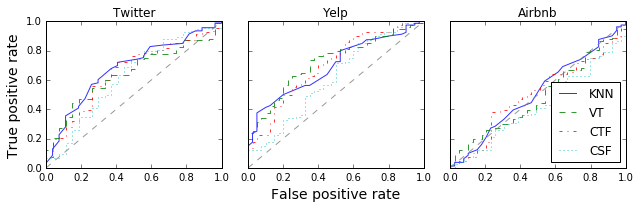

In [105]:
roc_auc_weightedAMT(file_path = AMT_path+'6_amt/results/')